## Notebook to research diabetes onset 


In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func)

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pmpm Canary data

In [3]:
%%time
canary_p = '../../../data/CANARY/CANARY/CANARY202104'
pmpm_p = '../../../temp/PMPM.p'
canary = pd.read_pickle(canary_p)
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 5.08 s, sys: 3.73 s, total: 8.81 s
Wall time: 8.83 s


### Process Canary, 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated

In [4]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 5.52 s, sys: 1.5 s, total: 7.02 s
Wall time: 7.02 s


### Keep Canary Patients from their date of registeration and onwards which did not have CC_DIABETES flag on, on their date of registration

In [5]:
%%time
treated2 = in_canary(treated.copy(), canary2)
treated2 = filter_first_month_diabetes(treated2.copy())
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 3.47 s, sys: 5.58 ms, total: 3.48 s
Wall time: 3.48 s


### For each patient in the treated group in its registartion month find a population of matched controls in the same month by using 

In [6]:
%%time

columns_to_match2 = ['ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT']
nn_func_args = {'match_on':columns_to_match2, 'neighbors_per_treated': 20}
matched, matched_data = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nn_func_args)

Mathcing Function: nearest_neighbor_func
CPU times: user 22min 19s, sys: 10min 28s, total: 32min 48s
Wall time: 32min 48s


### Run the Diabetes onset Function

In [7]:
matched_data = matched_data.drop_duplicates(subset = ['PERS_ID', 'MYR']).reset_index(drop = True)

In [8]:
%%time
con_onset = diabet_onset(matched_data.copy(), 'Diabetes_Con')
treated_onset = diabet_onset(treated2.copy(), 'Diabetes_Tr')
pmpm2 = filter_first_month_diabetes(pmpm.copy())
pmpm_onset = diabet_onset(pmpm2, 'Diabetes_PM')

CPU times: user 4min 15s, sys: 9.67 s, total: 4min 24s
Wall time: 4min 22s


In [9]:
con_onset2 = con_onset.rename(columns = {'Sample': 'Sample_Con', 'Per_1000':'Per_1000_Con'})
treated_onset2 = treated_onset.rename(columns = {'Sample': 'Sample_Tr', 'Per_1000':'Per_1000_Tr'})
pmpm_onset2 = pmpm_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})

joint = pd.concat((con_onset2, treated_onset2, pmpm_onset2), axis = 1)

### Diabetes Onset Per Month

1. **_Con : For Matched Controls Population**
2.  **_Tr : For Canary Treated Population**
3. **_PM : For the whole PMPM Population**


In [10]:
joint.describe().loc[['mean', 'std']]

Sample_Con  Diabetes_Con  Per_1000_Con   Sample_Tr  Diabetes_Tr  Per_1000_Tr      Sample_PM  Diabetes_PM  Per_1000_PM
mean  6084.459459     11.378378      1.559489  378.621622     0.648649     1.262788  141550.543478   275.369565     1.950861
std   5981.971240     11.674643      1.099662  387.260489     1.059775     2.631552   13456.572672    46.930852     0.301403

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')

In [12]:
joint2 = pd.concat((con_onset, treated_onset, pmpm_onset), axis = 1)
jointcon = joint2.Per_1000.iloc[1:, 0].reset_index()
jointTr = joint2.Per_1000.iloc[1:, 1].reset_index()
jointpmpm = joint2.Per_1000.iloc[1:, 2].reset_index()


**Plot Top Left**: $f(x)$ = Onset Per 1000 per month </br>
**Plot Top Right and Bottom Left**: $F(x) = \int_0^x f(y)dy$ Cumulative sum of the rates

No handles with labels found to put in legend.
No handles with labels found to put in legend.


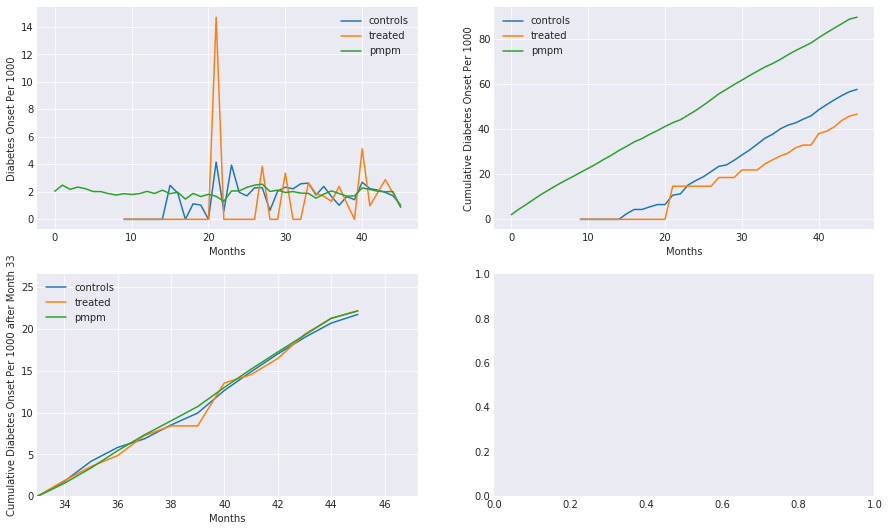

In [13]:
from diabetes_onset_plotter import plot_onset
f, ax = plot_onset(jointcon, jointTr, jointpmpm)
plt.show()

In [14]:
columns_to_match = ['AGE_AT_MIDMONTH','ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT']
pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
tr_desc = treated2[columns_to_match].describe().loc[['mean', 'std']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc = tr_desc.T

con_desc = matched_data[columns_to_match].describe().loc[['mean', 'std']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc = con_desc.T

pmpm_desc = pmpm2[columns_to_match].describe().loc[['mean', 'std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

alli = pd.concat((tr_desc, con_desc, pmpm_desc), axis = 1, keys = ['TREATED', 'MATCHED', 'PMPM'] )

### Univariate Distributions of our Populations

In [15]:
alli

TREATED                  MATCHED                     PMPM             
                       mean          std        mean          std        mean          std
AGE_AT_MIDMONTH   49.955875    12.375339   50.525855    12.722077   48.799608    19.377540
ALLOW_AMT        728.824987  4284.341584  689.806862  3131.865816  737.608200  4427.947637
MBR_GNDR           0.178636     0.383060    0.195710     0.396747    0.420833     0.493693
CC_TOBACCO         0.066511     0.249182    0.076607     0.265968    0.098876     0.298496
CC_PRESSURE        0.001747     0.041761    0.001761     0.041931    0.007079     0.083837
CC_OBESITY         0.494436     0.499985    0.457643     0.498204    0.227449     0.419185
CC_HYPERTENSION    0.315153     0.464592    0.318379     0.465848    0.282948     0.450432
CC_HYPOTHYROID     0.092391     0.289587    0.079032     0.269789    0.069469     0.254250
CC_DX_CNT          2.732272     2.113569    2.812949     2.164736    2.520817     2.540328